In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import doralite
import gfdl_utils.core as gu
import CM4Xutils

In [26]:
from CM4Xutils import *

In [28]:
grid_p25 = load_wmt_grid("CM4Xp25", test=True, dmget=True)
grid_p125 = load_wmt_grid("CM4Xp125", test=True, dmget=True)

Loading CM4Xp25-piControl.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Loading CM4Xp25-historical.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Assigning CM4Xp25 grid coordinates.
Loading CM4Xp125-piControl.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Loading CM4Xp125-historical.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Assigning CM4Xp125 grid coordinates.


In [37]:
import xbudget
budgets_dict_p25 = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid_p25, budgets_dict_p25)

budgets_dict_p125 = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid_p125, budgets_dict_p125)

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

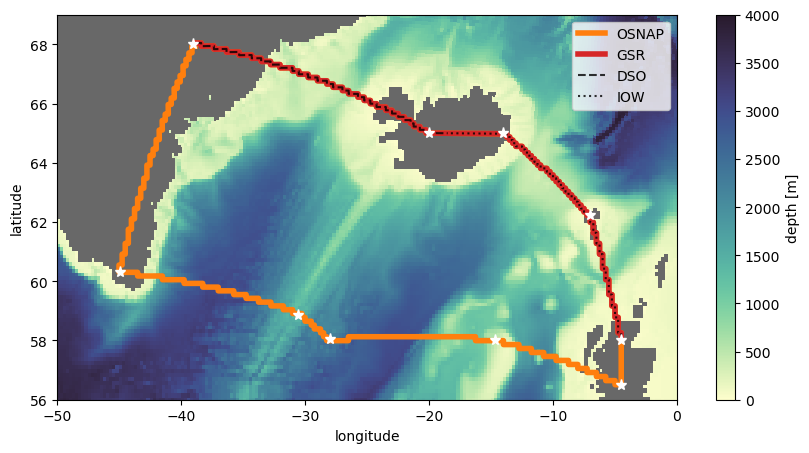

In [16]:
import matplotlib.pyplot as plt
import cmocean
import regionate
import xwmb

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "IrmingerIceland"
lons = np.array([-39.,  -20.,  -14,  -7.0, -4.5,  -4.5, -14.7, -28.00, -30.54, -44.90])
lats = np.array([ 68,     65,   65, 62.25,   58,  56.5,  58.0,  58.05,  58.86,  60.30])
region = regionate.GriddedRegion(name, lons, lats, grid_p125)

plt.figure(figsize=(10, 5))
p_ranges = {
    "DSO": np.arange(0, 110),
    "IOW": np.arange(110, 224),
    "GSR": np.arange(0, 224),
    "OSNAP-EAST": np.arange(224, region.lons.size),
}

pc = plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'],
    cmap=cmocean.cm.deep,
    vmin=0, vmax=4000
)
plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'].where(grid_p125._ds['deptho']==0)+1.,
    cmap="Greys", vmin=0, vmax=1.5
)
plt.colorbar(pc, label="depth [m]")

plt.plot(region.lons, region.lats, lw=4, color="C1", label="OSNAP")
plt.plot(region.lons[p_ranges["GSR"]], region.lats[p_ranges["GSR"]], lw=4, color="C3", label="GSR")
plt.plot(region.lons[p_ranges["DSO"]], region.lats[p_ranges["DSO"]], "--", color="k", lw=1.5, alpha=0.8, label="DSO")
plt.plot(region.lons[p_ranges["IOW"]], region.lats[p_ranges["IOW"]], ":", color="k", lw=1.5, alpha=0.8, label="IOW")
plt.plot(lons, lats, "w*", markersize=8)

plt.legend()
plt.xlabel("longitude");
plt.ylabel("latitude");

plt.ylim(56, 69)
plt.xlim(-50, 0);
plt.savefig("figures/OSNAP-East_map.png", dpi=250, bbox_inches="tight")

In [7]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [8]:
toSv = 1/1035*1e-6
wmt_mean = wmt.isel(exp=0).mean("time")*toSv
wmt_mean.load();

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_along = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb_along.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=True)

In [10]:
transport_mean = wmb_along.grid._ds['convergent_mass_transport_along'].isel(exp=0).mean("time")*toSv
transport_mean.load();

In [11]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

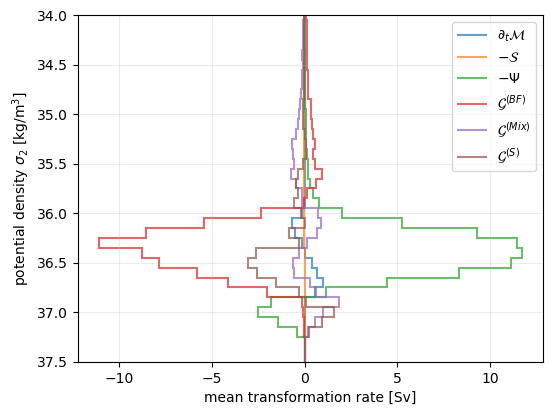

In [17]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\Psi$",                   **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(S)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.0);
plt.savefig("figures/OSNAP-East_water_mass_budget.png", dpi=250, bbox_inches="tight")

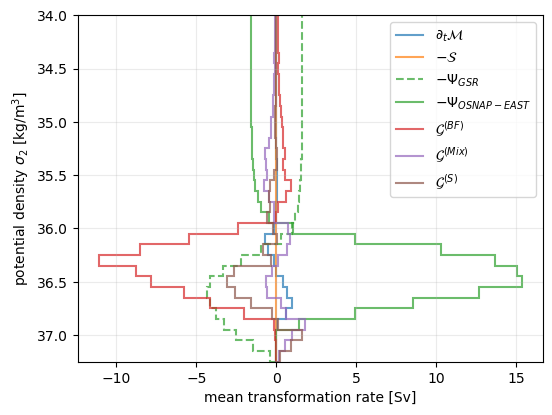

In [13]:
plt.figure(figsize=(6,4.5))

wmt_mean["convergent_mass_transport_GSR"] = transport_mean.isel(sect=p_ranges["GSR"]).sum("sect")
wmt_mean["convergent_mass_transport_OSNAP-EAST"] = transport_mean.isel(sect=p_ranges["OSNAP-EAST"]).sum("sect")

stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_GSR', label=r"$-\Psi_{GSR}$", **kwargs, color="C2", linestyle="--")
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-EAST', label=r"$-\Psi_{OSNAP-EAST}$", **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(S)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);

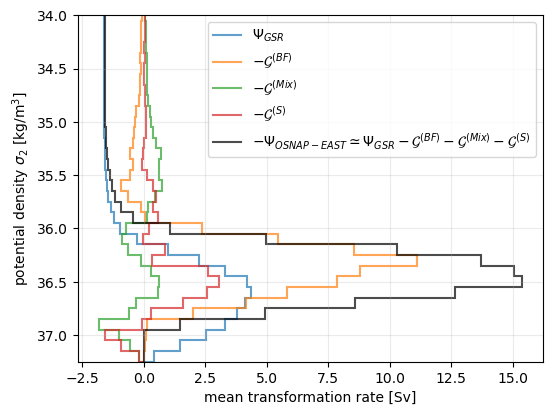

In [18]:
plt.figure(figsize=(6,4.5))

stairs(wmt_mean, 'convergent_mass_transport_GSR', label=r"$\Psi_{GSR}$", **kwargs)
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$",     **kwargs)
stairs(-wmt_mean, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(S)}$", **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-EAST', label=r"$-\Psi_{OSNAP-EAST} \simeq \Psi_{GSR} -\mathcal{G}^{(BF)} -\mathcal{G}^{(Mix)} -\mathcal{G}^{(S)}$", color="k", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);

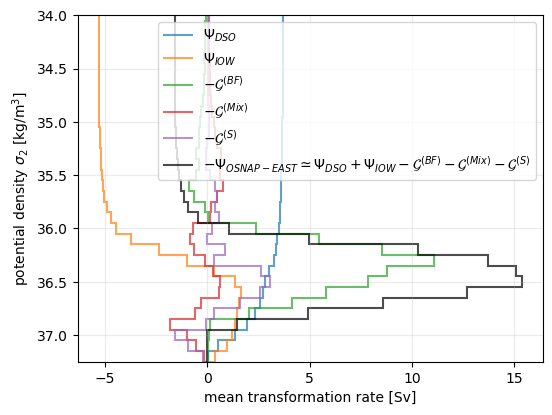

In [19]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean["convergent_mass_transport_DSO"] = transport_mean.isel(sect=p_ranges["DSO"]).sum("sect")
wmt_mean["convergent_mass_transport_IOW"] = transport_mean.isel(sect=p_ranges["IOW"]).sum("sect")

stairs(wmt_mean, 'convergent_mass_transport_DSO', label=r"$\Psi_{DSO}$", **kwargs)
stairs(wmt_mean, 'convergent_mass_transport_IOW', label=r"$\Psi_{IOW}$", **kwargs)
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$",     **kwargs)
stairs(-wmt_mean, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(S)}$", **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-EAST', label=r"$-\Psi_{OSNAP-EAST} \simeq \Psi_{DSO} + \Psi_{IOW} -\mathcal{G}^{(BF)} -\mathcal{G}^{(Mix)} -\mathcal{G}^{(S)}$", color="k", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);
plt.savefig("figures/OSNAP-East_outflow_decomposition.png", dpi=250, bbox_inches="tight")

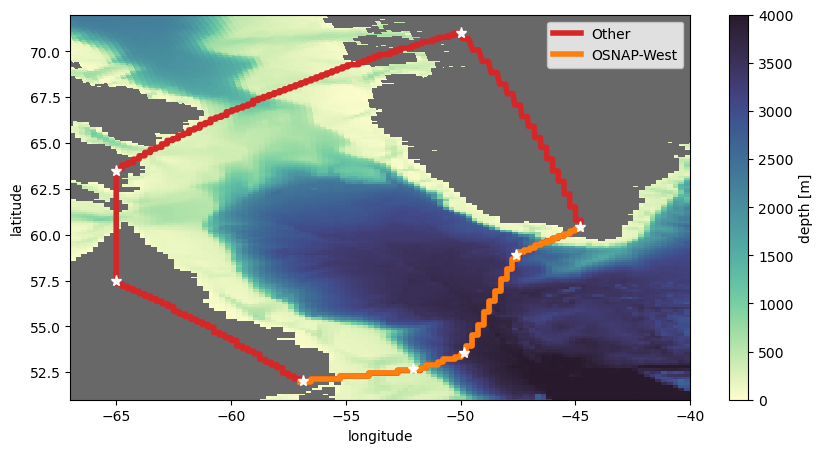

In [46]:
import matplotlib.pyplot as plt
import cmocean
import regionate
import xwmb

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "Labrador"
lons = np.array([-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50, -65, -65])
lats = np.array([52.0166, 52.6648, 53.5577, 58.8944, 60.4000, 71, 63.5, 57.5])

region = regionate.GriddedRegion(name, lons, lats, grid_p125)

plt.figure(figsize=(10, 5))
p_ranges = {
    "OSNAP-West": np.arange(0, 110),
    "OTHER": np.arange(110, region.lons.size),
}

pc = plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'],
    cmap=cmocean.cm.deep,
    vmin=0, vmax=4000
)
plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'].where(grid_p125._ds['deptho']==0)+1.,
    cmap="Greys", vmin=0, vmax=1.5
)
plt.colorbar(pc, label="depth [m]")

plt.plot(region.lons, region.lats, lw=4, color="C3", label="Other")
plt.plot(region.lons[p_ranges["OSNAP-West"]], region.lats[p_ranges["OSNAP-West"]], lw=4, color="C1", label="OSNAP-West")
plt.plot(lons, lats, "w*", markersize=8)

plt.legend()
plt.xlabel("longitude");
plt.ylabel("latitude");

plt.ylim(51, 72)
plt.xlim(-67,-40);
plt.savefig("figures/OSNAP-West_map.png", dpi=250, bbox_inches="tight")

In [39]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [41]:
toSv = 1/1035*1e-6
wmt_mean = wmt.isel(exp=0).mean("time")*toSv
wmt_mean.load();

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_along = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb_along.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=True)

In [43]:
transport_mean = wmb_along.grid._ds['convergent_mass_transport_along'].isel(exp=0).mean("time")*toSv
transport_mean.load();

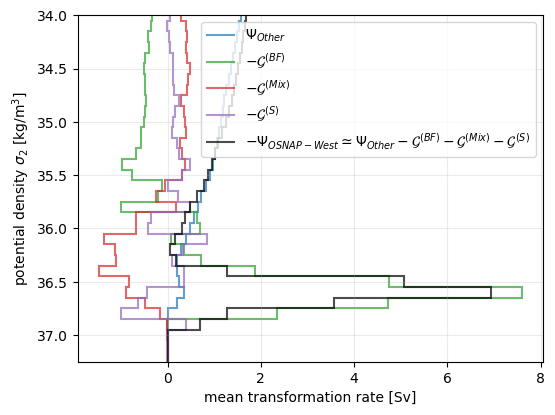

In [47]:
plt.figure(figsize=(6,4.5))

wmt_mean["convergent_mass_transport_OSNAP-West"] = transport_mean.isel(sect=p_ranges["OSNAP-West"]).sum("sect")
wmt_mean["convergent_mass_transport_OTHER"] = transport_mean.isel(sect=p_ranges["OTHER"]).sum("sect")

stairs(wmt_mean, 'convergent_mass_transport_OTHER', label=r"$\Psi_{Other}$", **kwargs)
plt.plot([], [])
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$",     **kwargs)
stairs(-wmt_mean, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(S)}$", **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-West', label=r"$-\Psi_{OSNAP-West} \simeq \Psi_{Other} -\mathcal{G}^{(BF)} -\mathcal{G}^{(Mix)} -\mathcal{G}^{(S)}$", color="k", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);
plt.savefig("figures/OSNAP-West_outflow_decomposition.png", dpi=250, bbox_inches="tight")